# Plot GECO Logged data

In [21]:
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import argparse
import pandas as pd
import os

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [76]:
class GECOPlotter():
  def __init__(self, file_list=[]) -> None:
    self.file_list = file_list
    self.merge_data()
    self.find_all_channels()
    self.color_list=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'blue', 'limegreen', 'magenta', 'cyan']
    self.abnormality_datetime={}
    self.abnormality_threshold=1 # 1 percent


  def merge_data(self):
    file_list = self.file_list
    #mypaser = lambda x: pd.to_datetime.strptime(x, "%Y-%m-%dT%H:%M:%S")
    self.df = pd.DataFrame(columns=['timestamp', 'ch_id', 'par_name', 'par_value'])
    for f in file_list:
      df = pd.read_csv(f,  parse_dates=['timestamp'])
      self.df = self.df.append(df)# this method has been depreciated in panda
      #pd.concat([self.df, df])
      
  def find_all_channels(self):
    df = self.df
    all_ch = pd.unique(df['ch_id'])
    self.all_ch = all_ch

  def get_imon_trend(self, ch_id):

    df = self.df
    mask = (df['par_name'] == 'IMon') & (df['ch_id'] == ch_id)
    t = df.loc[mask]['timestamp']
    y = df.loc[mask]['par_value']
    return t, y

  def get_vmon_trend(self, ch_id):
    df = self.df
    mask = (df['par_name'] == 'VMon') & (df['ch_id'] == ch_id)
    t = df.loc[mask]['timestamp']
    y = df.loc[mask]['par_value']
    return t, y

  def plot_all_imon_trend(self, use_percentage=False, save_fig=False, fig_format='pdf', t_range=None, y_range=None,
                          incidence_dict={},
                          skipped_period=[]):
    """
    Args:
      save_fig: bool
      fig_format: str. options: pdf, png. If save_fig=False, this argument is ignored.
    """
    if save_fig:
      if use_percentage:
        fig_name="IMon_pct_all.%s" % fig_format
      else:
        fig_name="IMon_uA_all.%s" % fig_format
      
    ncols = 5
    nrows = 13
    plt.figure(figsize=[4*ncols,3*nrows], dpi=90)
    plt_ctr=0
    for i, k in enumerate(sorted(gp.all_ch)):
      ax = plt.subplot(nrows,ncols,plt_ctr+1)
      t, y = self.get_imon_trend(k)
      #print('y',y)
      for sp in skipped_period:
        t0=datetime.strptime(sp[0], '%y%m%dT%H%M')
        t1=datetime.strptime(sp[1], '%y%m%dT%H%M')
        mask = (t >= t0) & (t < t1)
        t = t[~mask]
        y = y[~mask]
      ym = np.mean(y)
      if ym<200:
        continue
      if use_percentage==False:
        plt.plot(t, y, label='HV ch_id=%d' % k, marker='None', color='k')
        #print('ym',ym)
        plt.ylabel('IMon [uA]')
      else:
        y = y.to_numpy()
        ym=np.mean(y)
        y_pct = (y-ym)/ym*100
        abn_mask = abs(y_pct)>self.abnormality_threshold
        if len(y_pct[abn_mask])>0:
          self.abnormality_datetime[k]=t[abn_mask]
        plt.plot(t, y_pct, label='HV ch_id=%d' % k, marker='None',  color='k')
        plt.ylabel('IMon Variation [%]')
      icd_ctr = 0
      for k, v in incidence_dict.items():
        t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
        t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
        ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr])
        icd_ctr += 1
      plt_ctr+=1
      plt.xticks(rotation=45, fontsize=9)
      plt.legend()
    # end chan loop
    # one more plot for legend
    ax = plt.subplot(nrows,ncols,plt_ctr+1)
    plt.plot(t, y, marker='None', alpha=0)
    icd_ctr = 0
    for k, v in incidence_dict.items():
      t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
      t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
      ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr], label=k)
      icd_ctr += 1
      plt.xticks(rotation=45, fontsize=9)
      ax.get_yaxis().set_visible(False)
      plt.legend()
      if t_range:
        plt.xlim(t_range)
      if y_range:
        plt.ylim(y_range)
    plt.tight_layout()
    if save_fig:
      dir=os.path.dirname(gp.file_list[0])
      if len(gp.file_list)==1:
        fig_name = gp.file_list[0][:-4]+'.'+fig_format
        if use_percentage:
          fig_name = fig_name.replace('_VMon_', '_pct_')
        else:
          fig_name = fig_name.replace('_VMon_', '_uA_')
      else:
          fig_name = dir + '/' + fig_name
      plt.savefig(fig_name)
      print('Info: save fig to', fig_name)
    plt.show()

  def plot_all_vmon_trend(self, use_percentage=False, save_fig=False, fig_format='pdf', 
                          incidence_dict={},
                          skipped_period=[]):
    """
    Args:
      save_fig: bool
      fig_format: str. options: pdf, png. If save_fig=False, this argument is ignored.
    """
    if save_fig:
      if use_percentage:
        fig_name="VMon_pct_all.%s" % fig_format
      else:
        fig_name="VMon_V_all.%s" % fig_format
      
    ncols = 5
    nrows = 13
    plt.figure(figsize=[4*ncols,3*nrows], dpi=90)
    plt_ctr=0
    for i, k in enumerate(sorted(gp.all_ch)):
      ax = plt.subplot(nrows,ncols,plt_ctr+1)
      t, y = self.get_vmon_trend(k)
      #By Ryan debug
      #print('t', t)
      for sp in skipped_period:
        t0=datetime.strptime(sp[0], '%y%m%dT%H%M')
        t1=datetime.strptime(sp[1], '%y%m%dT%H%M')
        mask = (t >= t0) & (t < t1)
        t = t[~mask]
        y = y[~mask]
      ym = np.mean(y)
      if ym<800:
        continue
      if use_percentage==False:
        plt.plot(t, y, label='HV ch_id=%d' % k, marker='None', color='k')
        plt.ylabel('VMon [V]')
      else:
        y = y.to_numpy()
        ym=np.mean(y)
        y_pct = (y-ym)/ym*100
        abn_mask = abs(y_pct)>self.abnormality_threshold
        if len(y_pct[abn_mask])>0:
          self.abnormality_datetime[k]=t[abn_mask]
        plt.plot(t, y_pct, label='HV ch_id=%d' % k, marker='None',  color='k')
        plt.ylabel('VMon Variation [%]')
      icd_ctr = 0
      for k, v in incidence_dict.items():
        t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
        t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
        ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr])
        icd_ctr += 1
      plt_ctr+=1
      plt.xticks(rotation=45, fontsize=9)
      plt.legend()
    # end chan loop
    # one more plot for legend
    ax = plt.subplot(nrows,ncols,plt_ctr+1)
    plt.plot(t, y, marker='None', alpha=0)
    icd_ctr = 0
    for k, v in incidence_dict.items():
      t0 = datetime.strptime(v[0], '%y%m%dT%H%M')
      t1 = datetime.strptime(v[1], '%y%m%dT%H%M')
      ax.axvspan(t0, t1, alpha=0.2, color=self.color_list[icd_ctr], label=k)
      icd_ctr += 1
      plt.xticks(rotation=45, fontsize=9)
      ax.get_yaxis().set_visible(False)
      plt.legend()
    
    plt.tight_layout()
    if save_fig:
      dir=os.path.dirname(gp.file_list[0])
      if len(gp.file_list)==1:
        fig_name = gp.file_list[0][:-4]+'.'+fig_format
        if use_percentage:
          fig_name = fig_name.replace('_VMon_', '_pct_')
        else:
          fig_name = fig_name.replace('_VMon_', '_uA_')
      else:
          fig_name = dir + '/' + fig_name
      plt.savefig(fig_name)
      print('Info: save fig to', fig_name)
    plt.show()

In [77]:
file_path = [
    '/home/wangbtc/VMon_IMon_230726T1508.csv',
    ]

/tmp/ipykernel_7316/3913553471.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df)# this method has been depreciated in panda


Info: save fig to /home/wangbtc/VMon_IMon_230726T1508.pdf


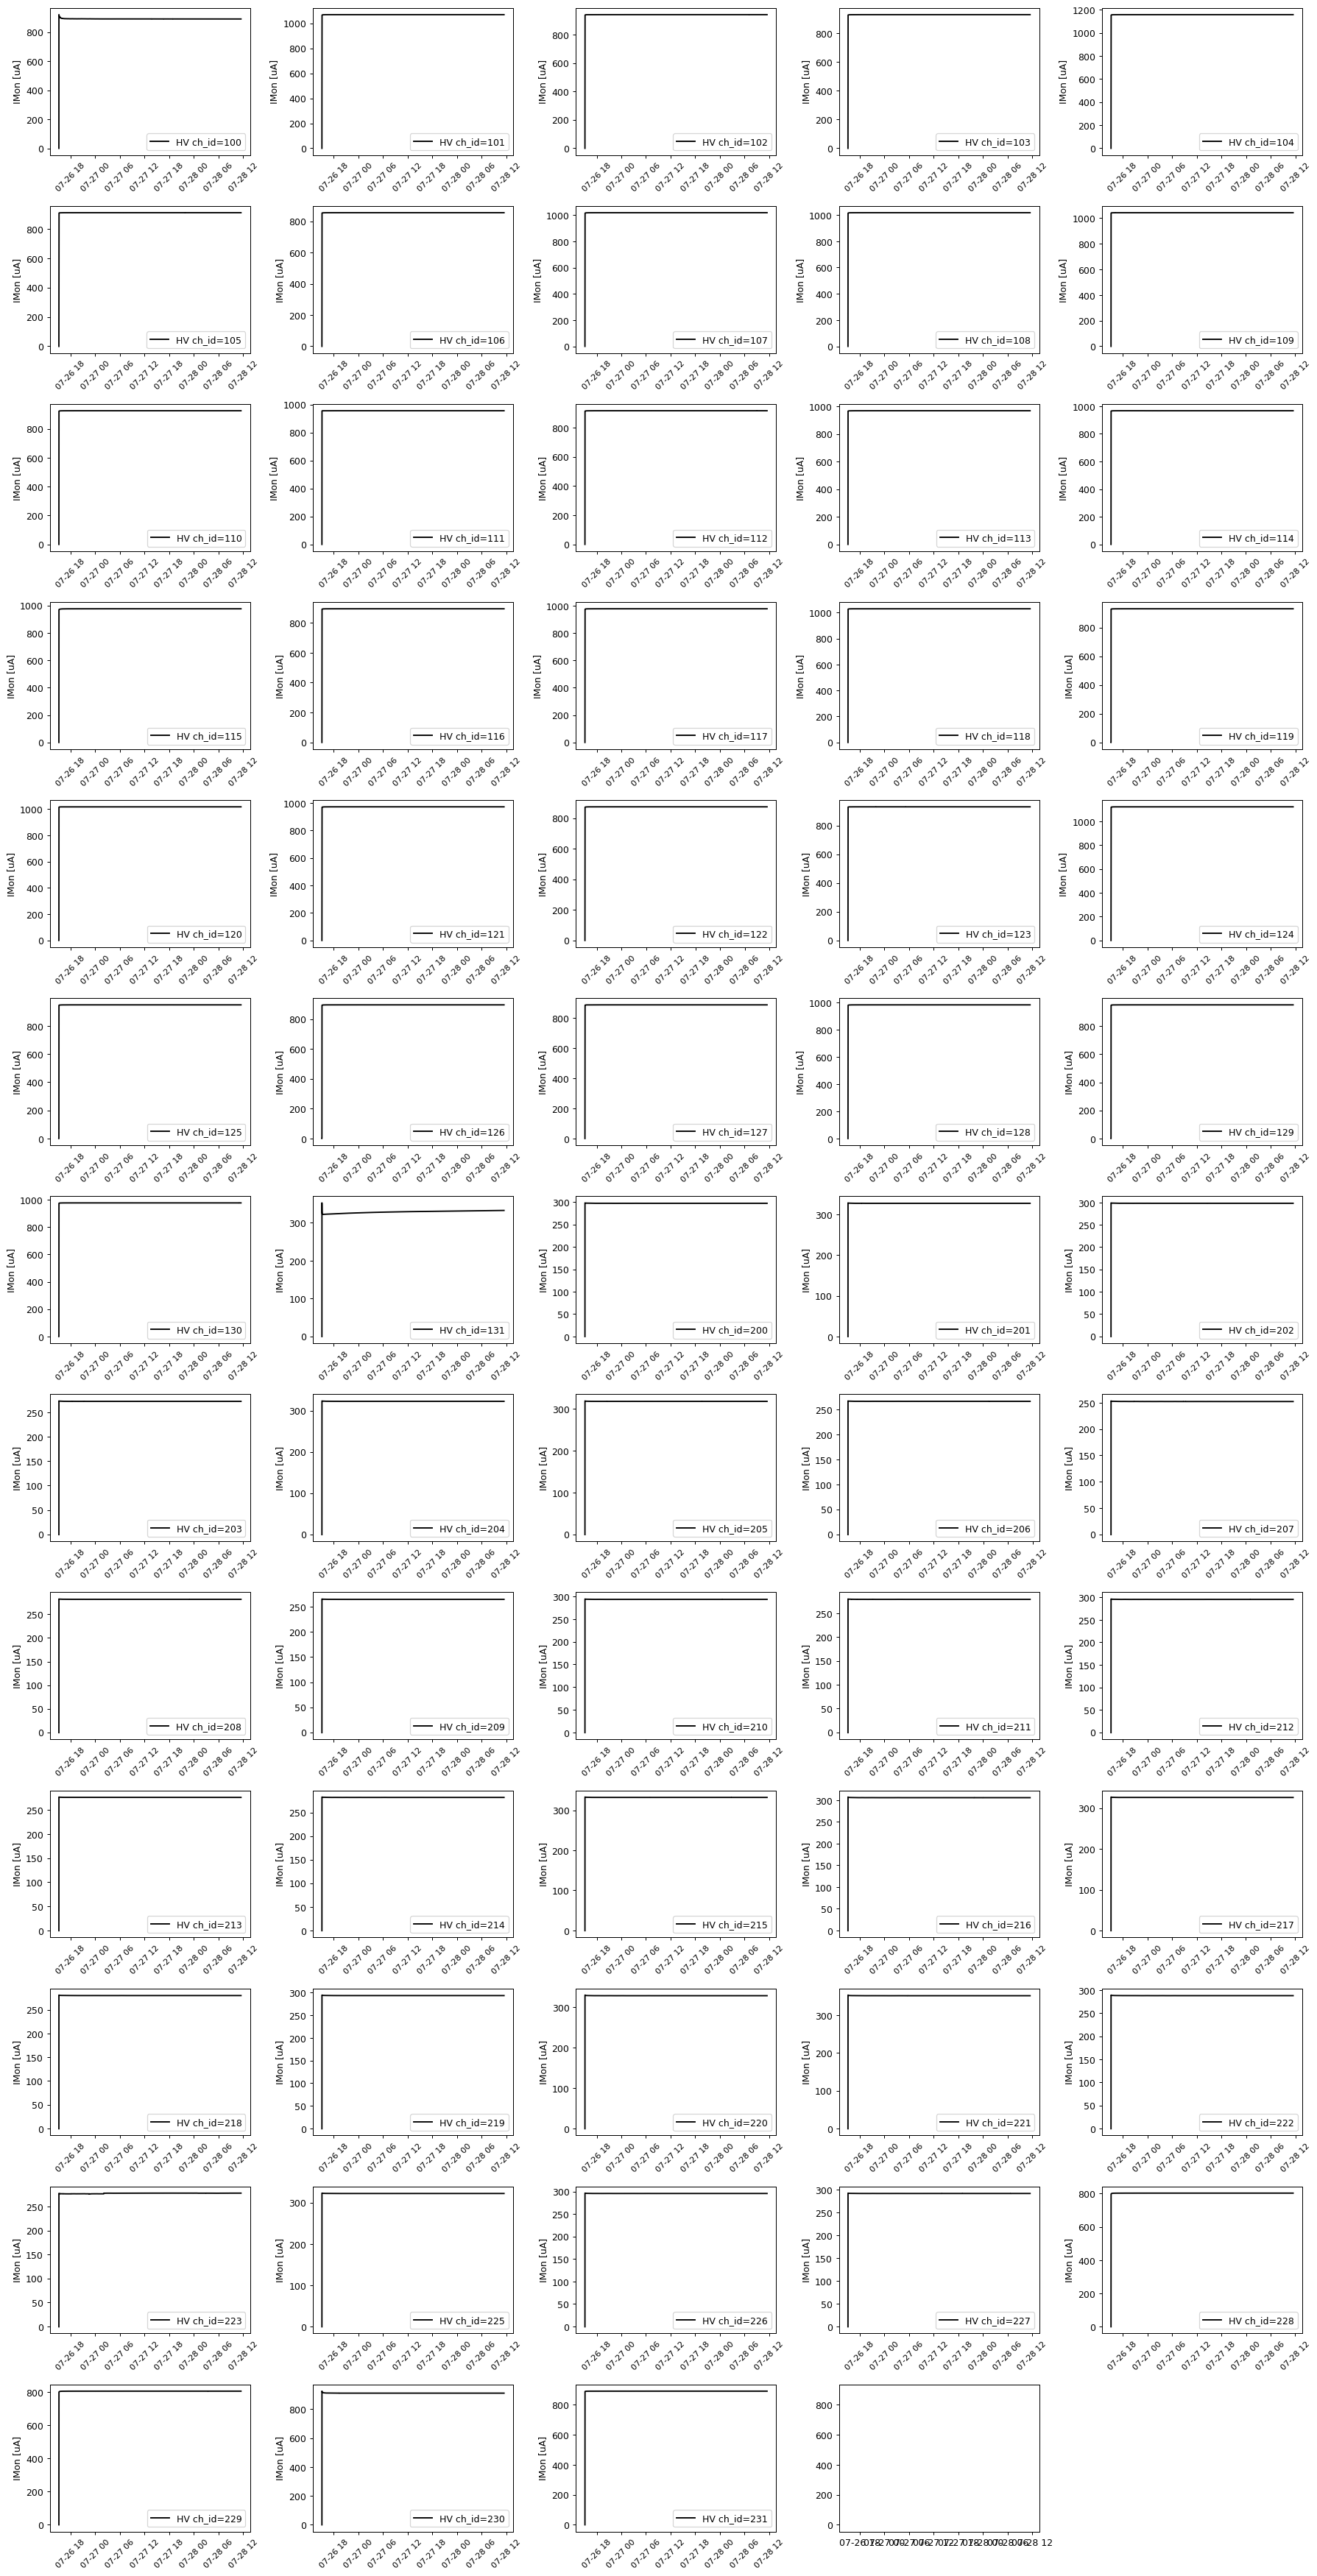

In [79]:
gp = GECOPlotter(file_path)

skipped_period=[
     ['600', '1000']
     ]

gp.plot_all_imon_trend(use_percentage=False, save_fig=True, fig_format='pdf', t_range=(datetime(2023, 7, 28), datetime(2023, 7, 28)))


Info: save fig to /home/wangbtc/VMon_IMon_230726T1508.pdf


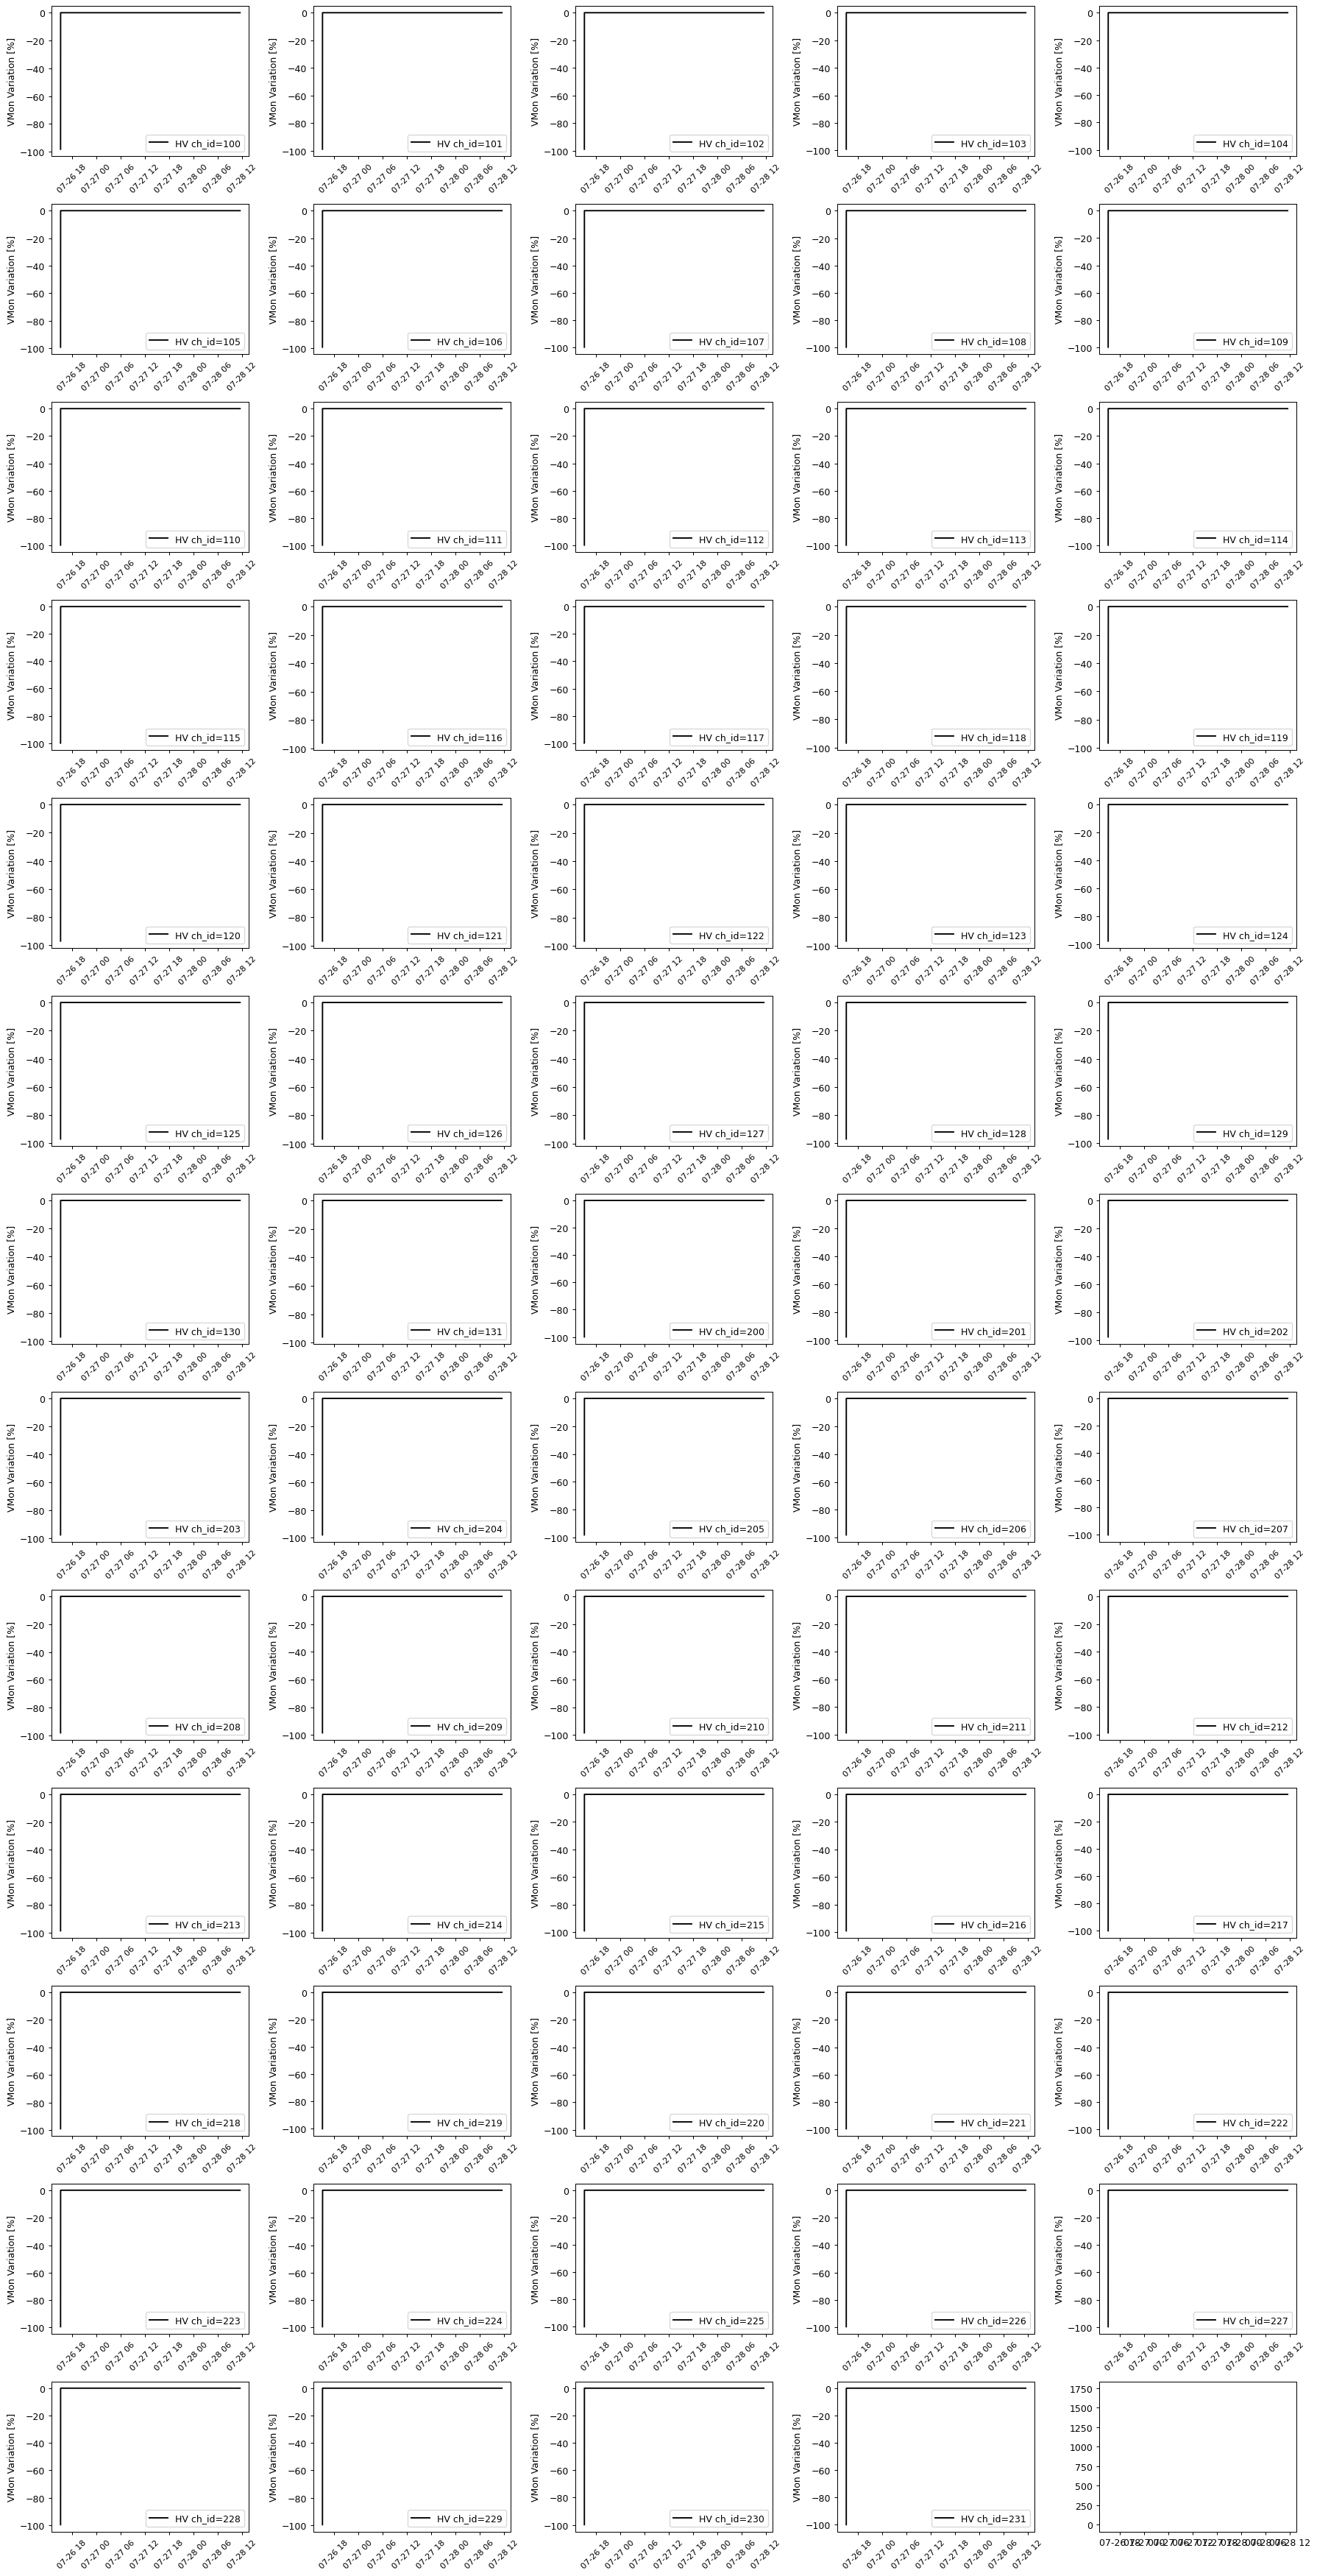

In [37]:
gp.plot_all_vmon_trend(use_percentage=True, save_fig=True, fig_format='pdf')